In [1]:
import time
import math
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
ts_data = pd.read_csv('../data/it-data-4metrics.csv', sep=',')
ts_data = ts_data.iloc[:,0:4]

In [3]:
# Creation of the dictionnary of all the metric_name in association with their metric_id
dic_name = {}
dic_id = {}
for indx in ts_data.index:
    if ts_data['metric_name'][indx] not in dic_name.keys():
        dic_name[ts_data['metric_name'][indx]] = []
    if ts_data['metric_id'][indx] not in dic_name[ts_data['metric_name'][indx]]:
        dic_name[ts_data['metric_name'][indx]].append(ts_data['metric_id'][indx])
        dic_id[ts_data['metric_id'][indx]] = [ts_data['metric_name'][indx]]
keys_name = list(dic_name.keys())
keys_id = list(dic_id.keys())

In [4]:
# Split the data into training/validating sets
for indx in keys_id:
    indexNames = ts_data[ ts_data['metric_id'] == indx ].index
    data = ts_data.iloc[indexNames].sort_values(by='timestamp', ascending=True)
    dic_id[indx].append(data['value'].to_numpy())
    
    training_limite = int(0.66*data.shape[0])
    training = data.iloc[:training_limite]
    validating = data.iloc[training_limite:]

    # Split the outcome values from the input dataset
    x_train = training['timestamp'].to_numpy().reshape(-1, 1)
    y_train = training['value']
    x_valid = validating['timestamp'].to_numpy().reshape(-1, 1)
    y_valid = validating['value']

    # Create linear regression object
    dtree = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=10)
    
    # Train the model using the training sets
    start_train = time.time()
    dtree.fit(x_train, y_train)
    end_train = time.time()
    # Make predictions using the testing set
    start_val = time.time()
    y_valid_pred = dtree.predict(x_valid)
    end_val = time.time()
    y_train_pred = dtree.predict(x_train)

    
    dic_id[indx].append(r2_score(y_valid, y_valid_pred)*100)
    dic_id[indx].append([x_train, y_train, y_train_pred])    
    dic_id[indx].append([x_valid, y_valid, y_valid_pred])    
    dic_id[indx].append(end_train-start_train)    
    dic_id[indx].append(end_val-start_val)
    dic_id[indx].append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

In [5]:
# Here we have two dictionaries:
# First, we have a link between the metric_name and their metric_id

# {'metric_name_1':[metric_id_1, metric_id_2, ...],
#  'metric_name_2':[metric_id_1, metric_id_2, ...],
#  ...}


# Second, we have all the information according to the metric_id

# {'metric_id_1':[metric_name_x, data['value'],r2, [x_train, y_train, y_train_pred], [x_valid, y_valid, y_valid_pred], training_time, inference_time, rms],
#  'metric_id_2':[metric_name_y, data['value'],r2, [x_train, y_train, y_train_pred], [x_valid, y_valid, y_valid_pred], training_time, inference_time, rms],
#  ...}
# 

In [6]:
pd.DataFrame(dic_id).to_csv('DT_bis.csv', encoding='utf-8')

<ipython-input-7-e4a9fc1acb2b>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<function matplotlib.pyplot.show(close=None, block=None)>

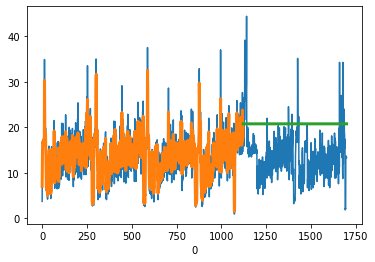

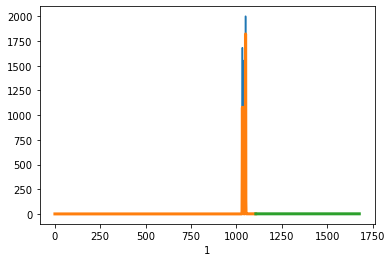

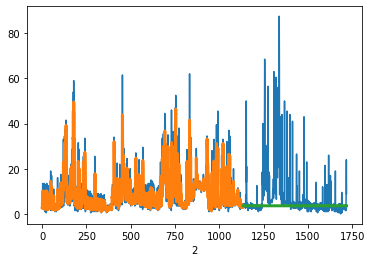

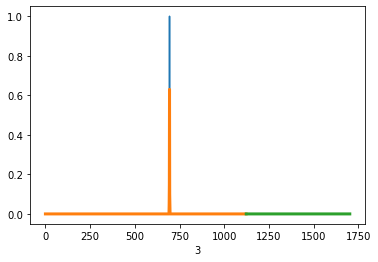

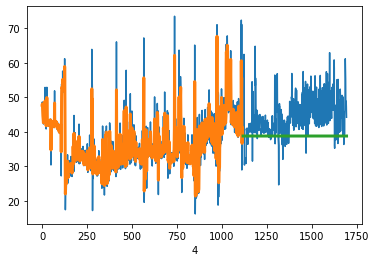

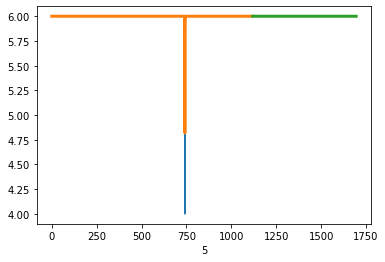

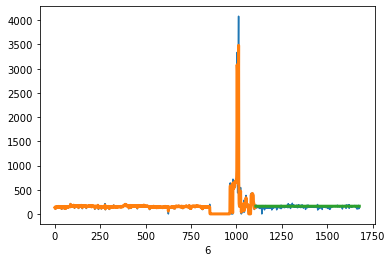

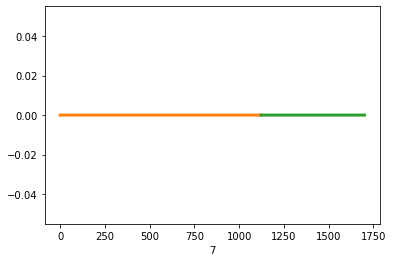

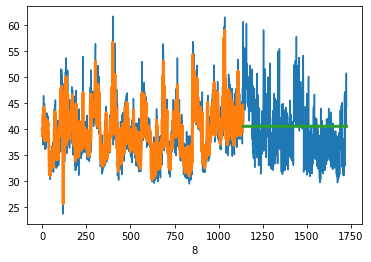

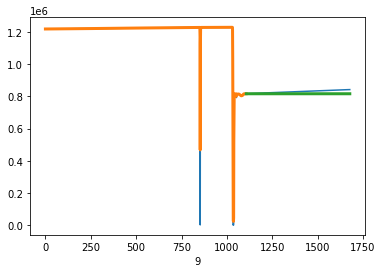

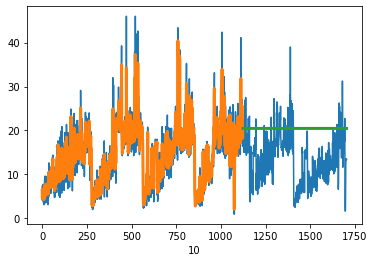

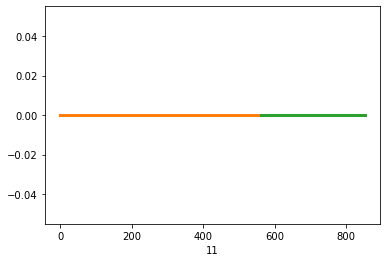

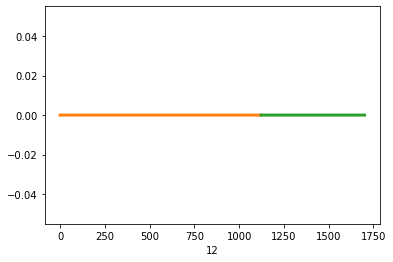

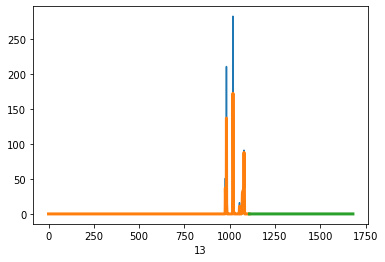

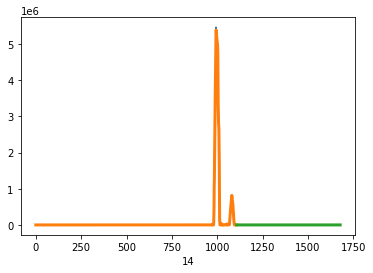

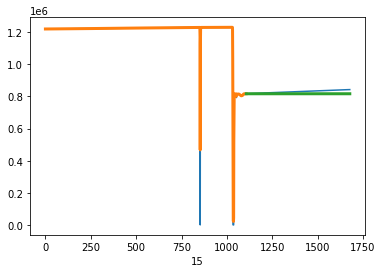

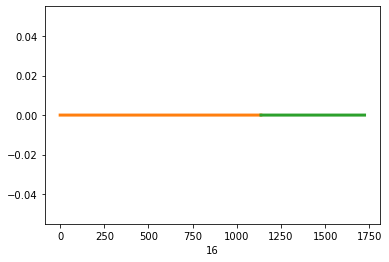

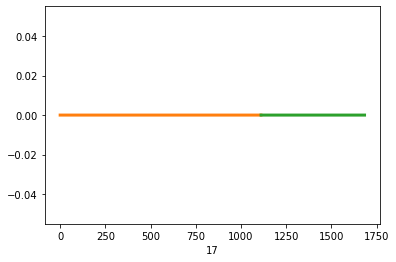

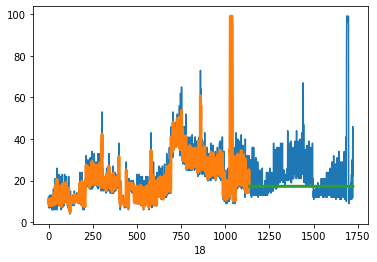

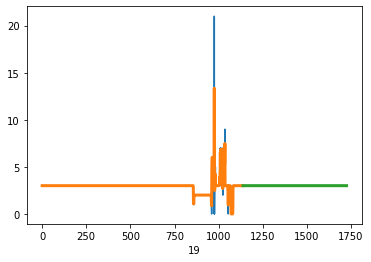

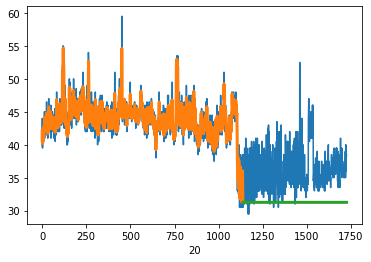

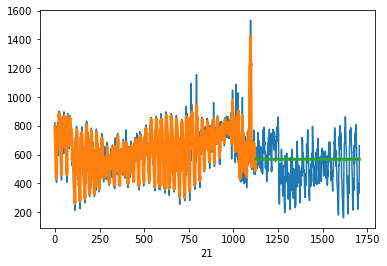

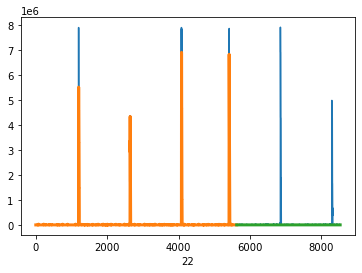

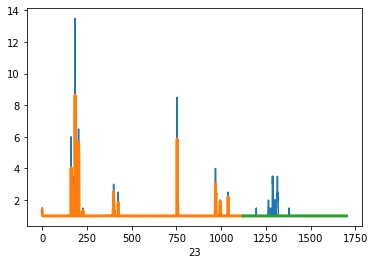

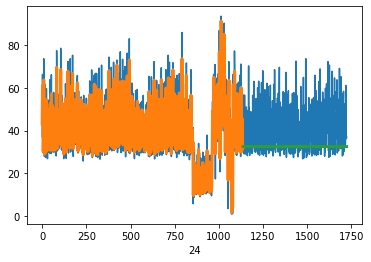

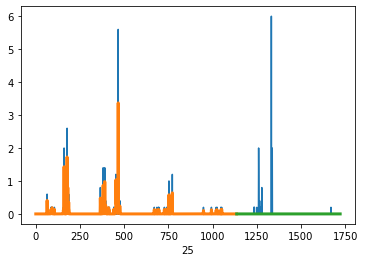

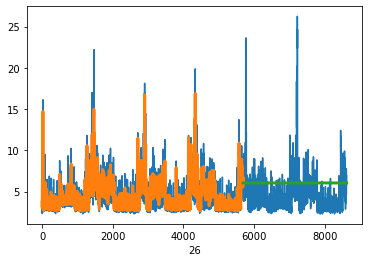

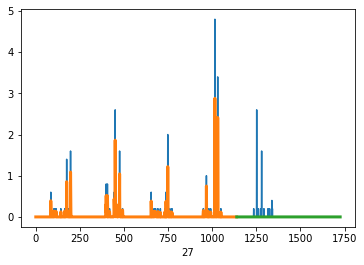

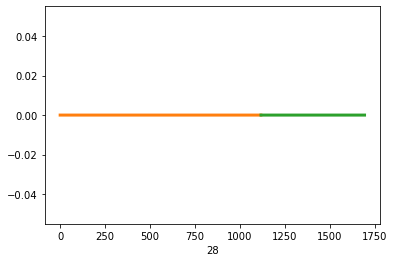

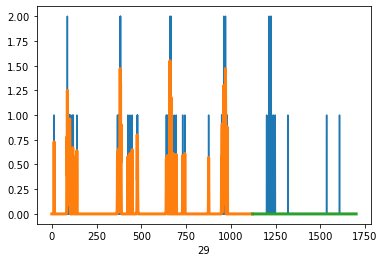

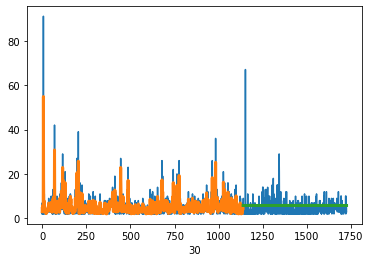

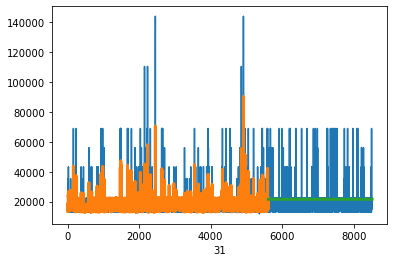

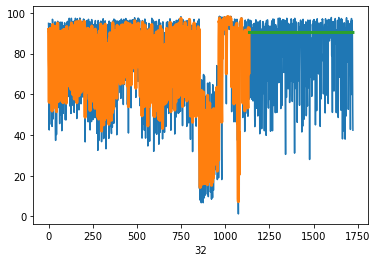

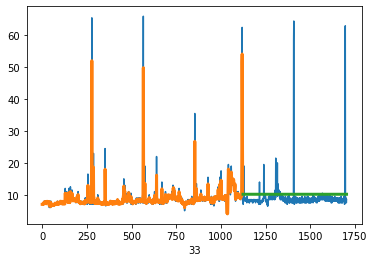

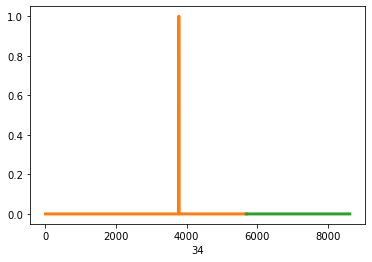

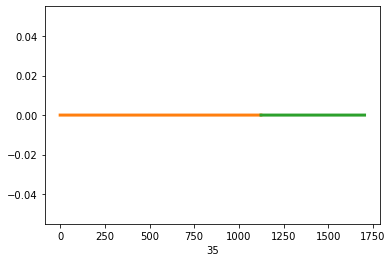

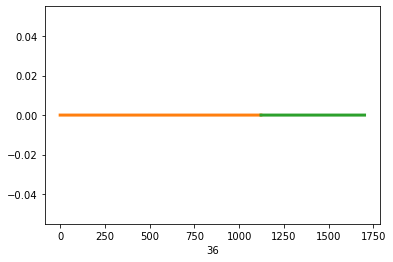

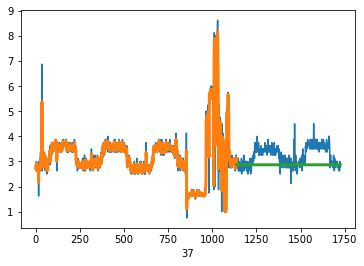

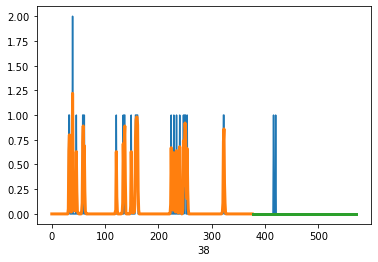

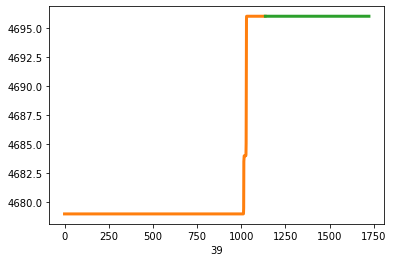

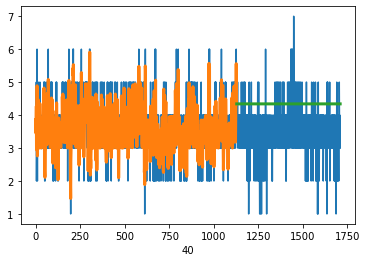

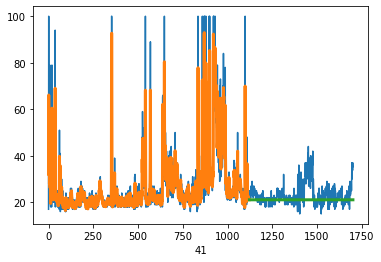

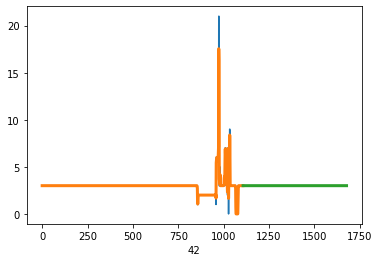

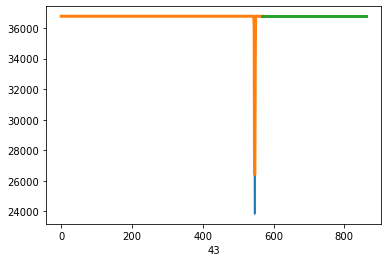

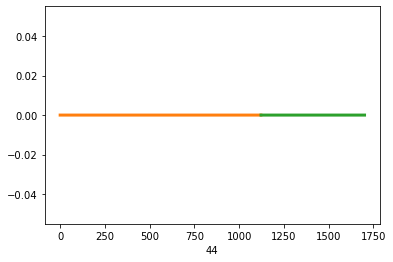

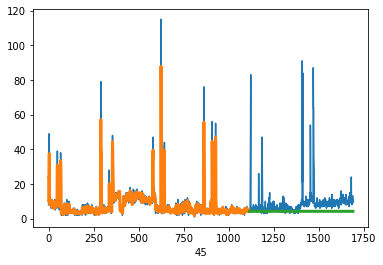

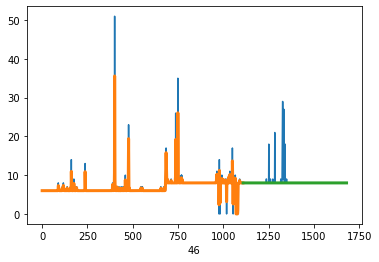

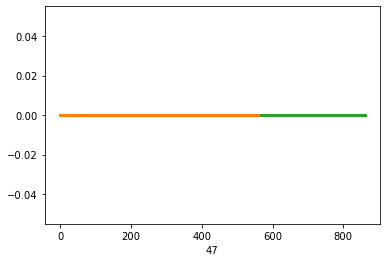

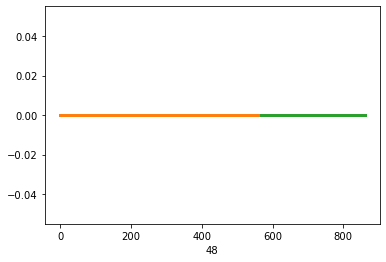

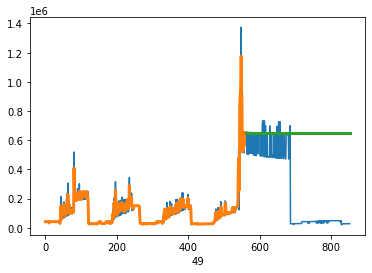

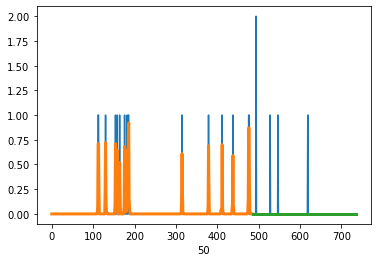

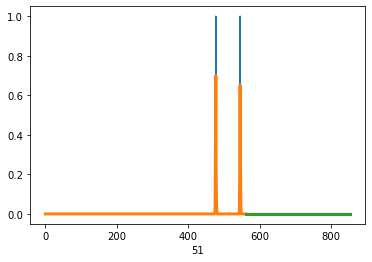

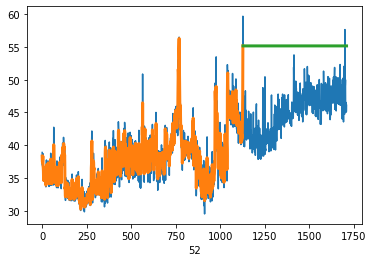

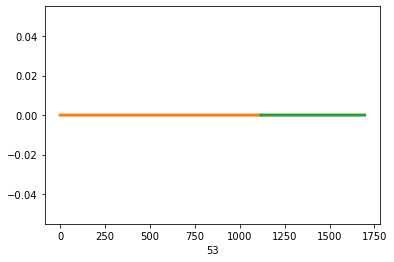

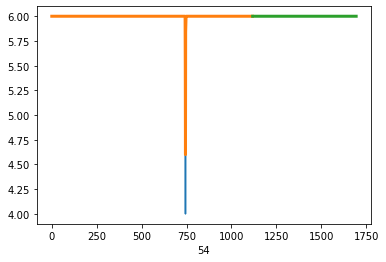

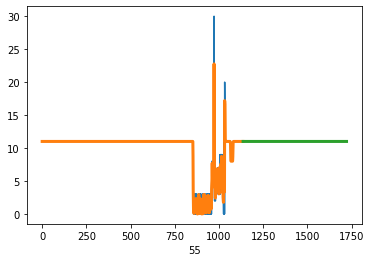

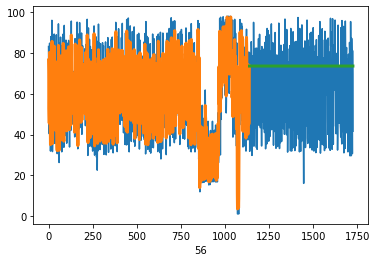

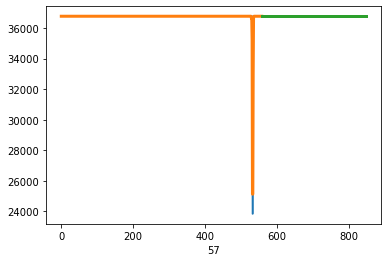

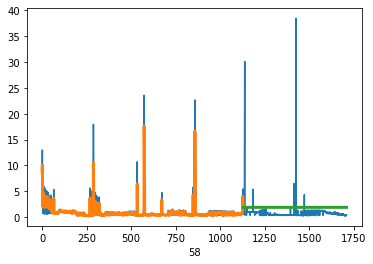

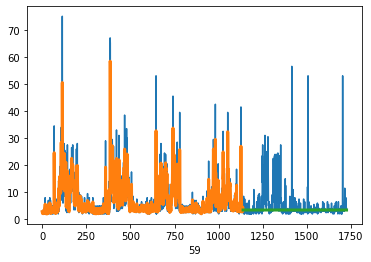

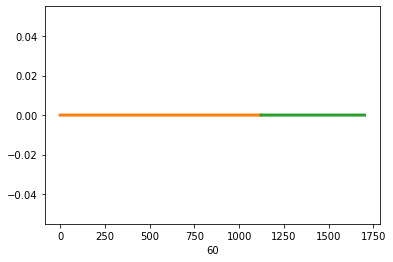

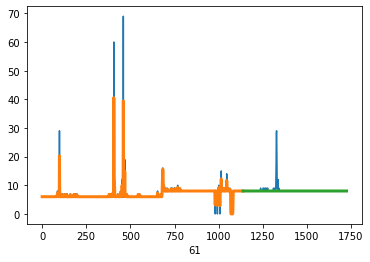

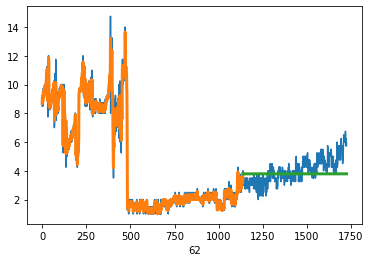

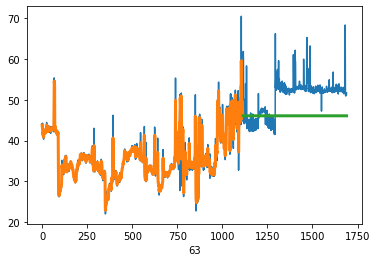

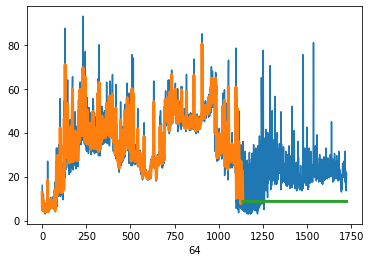

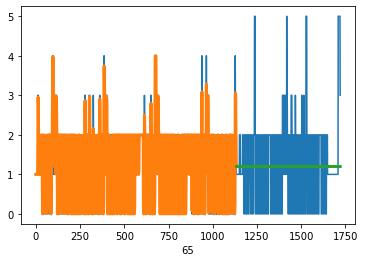

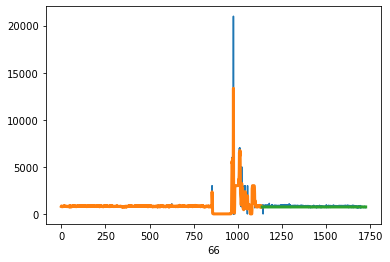

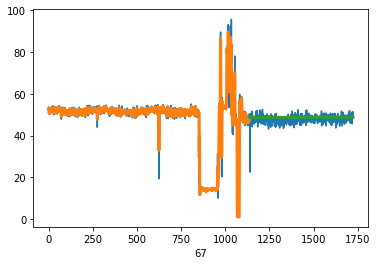

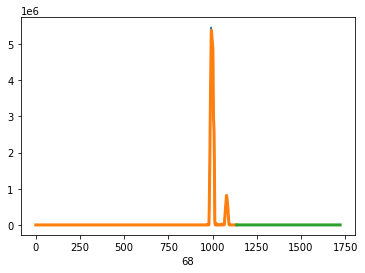

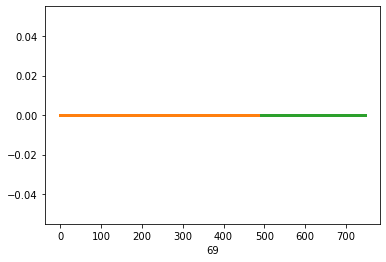

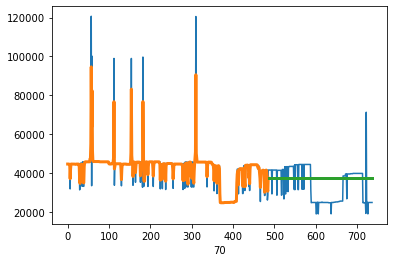

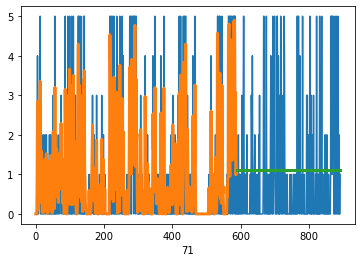

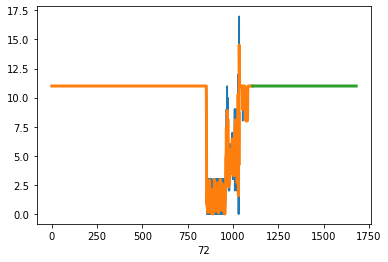

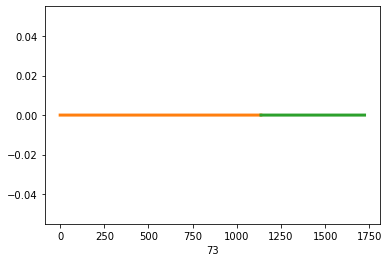

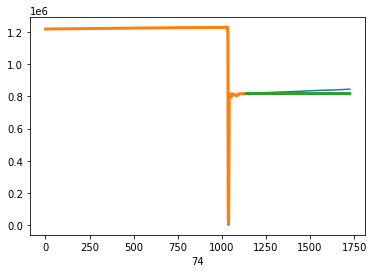

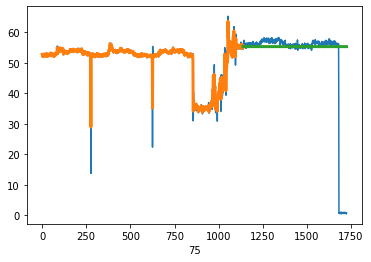

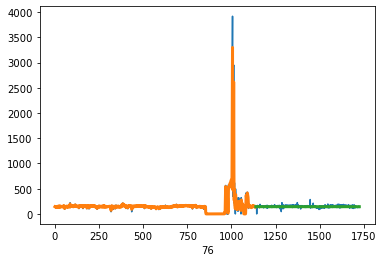

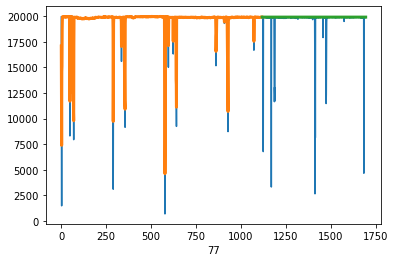

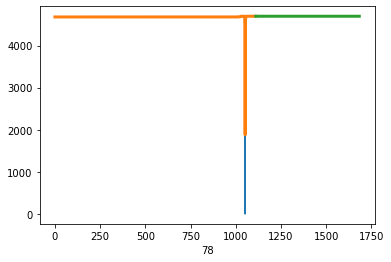

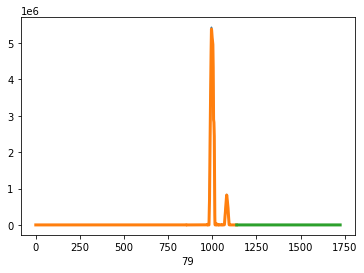

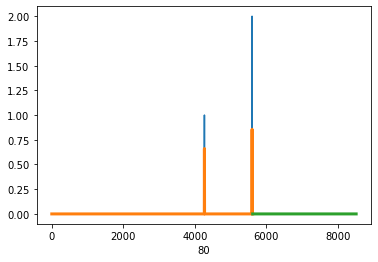

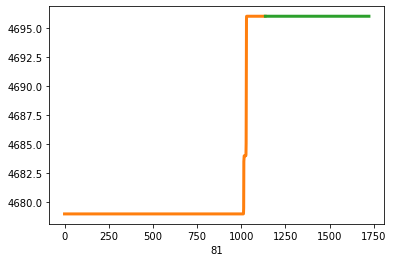

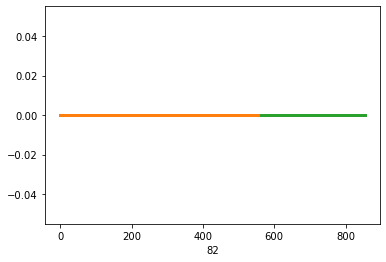

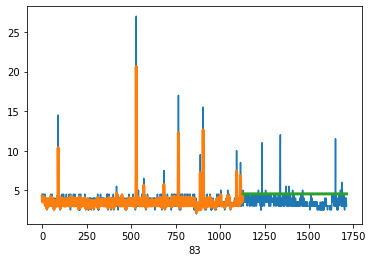

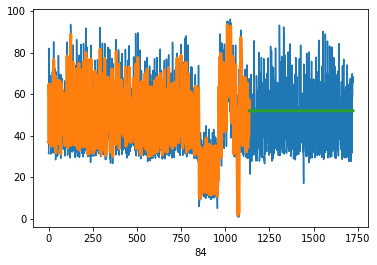

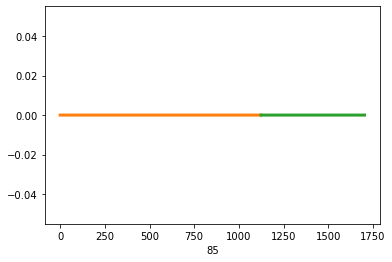

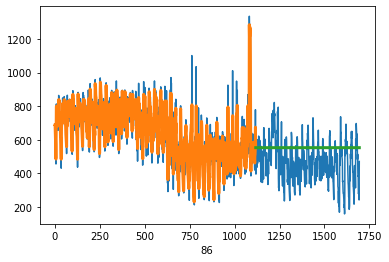

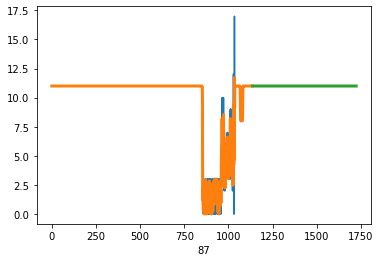

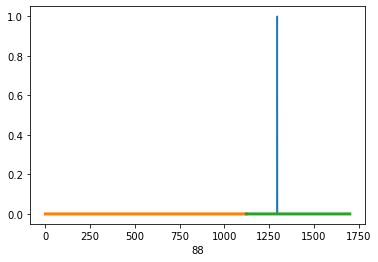

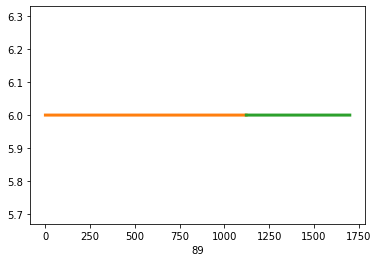

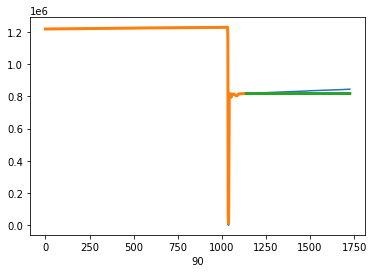

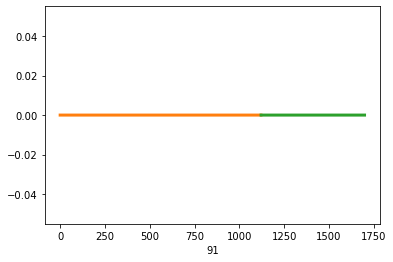

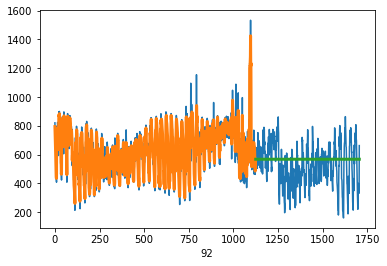

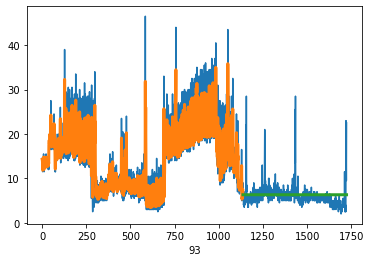

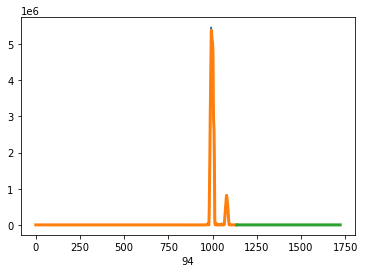

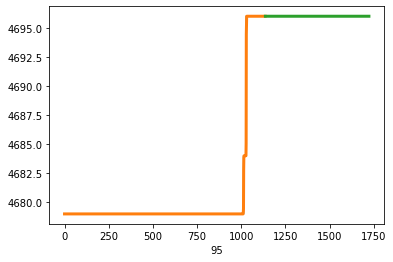

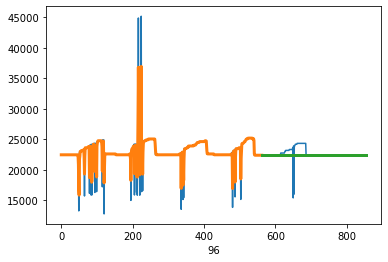

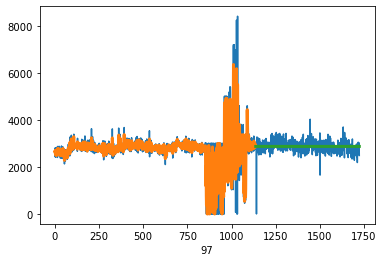

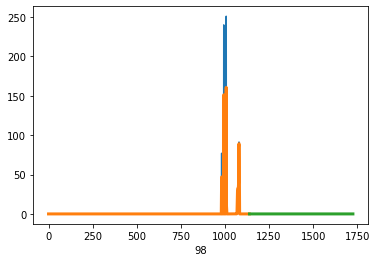

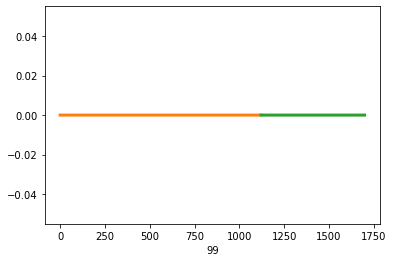

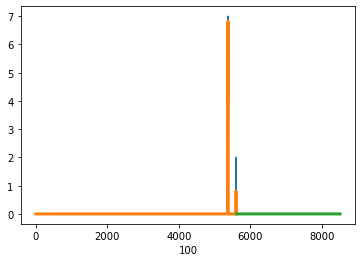

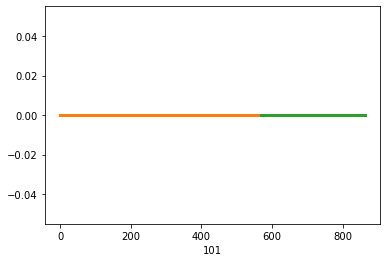

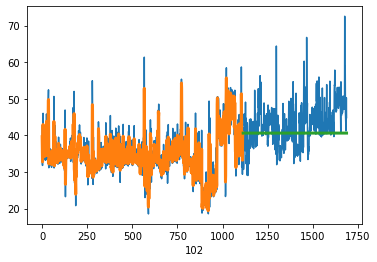

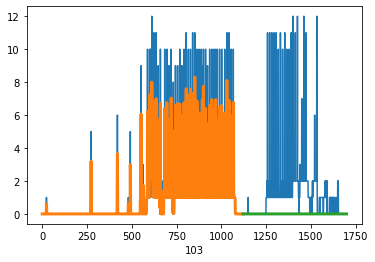

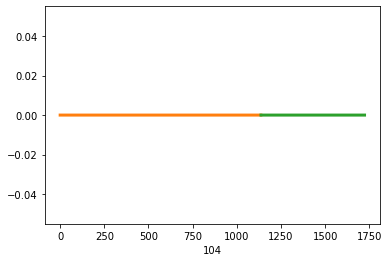

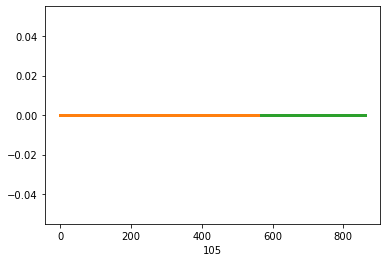

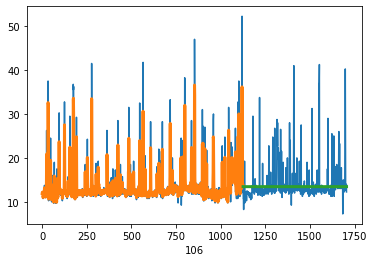

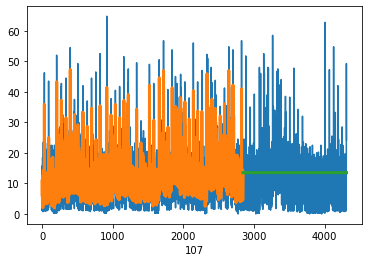

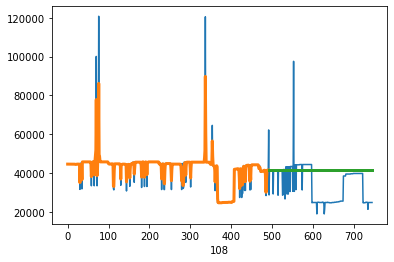

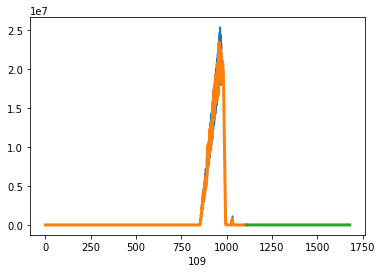

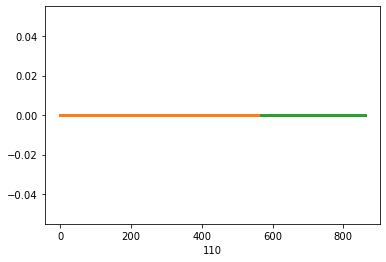

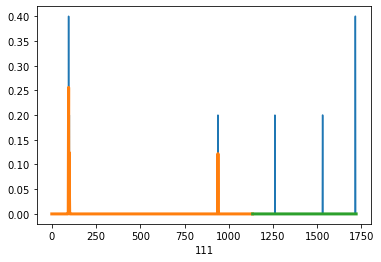

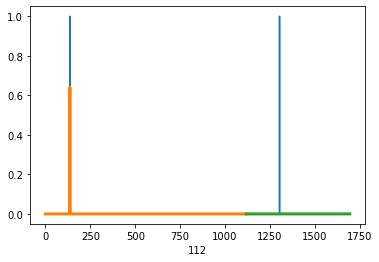

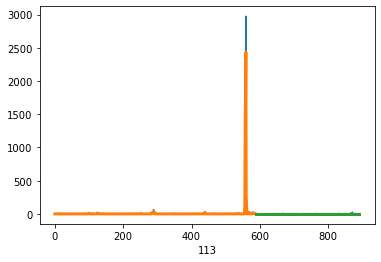

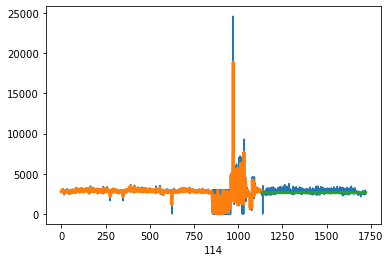

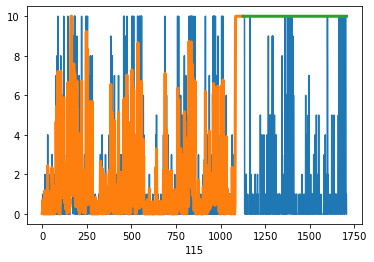

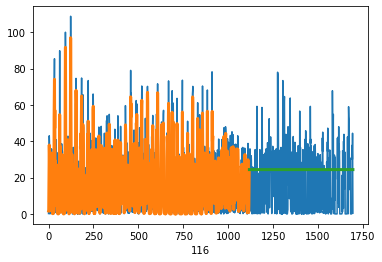

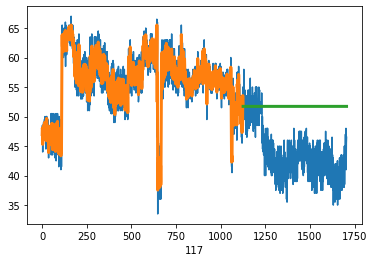

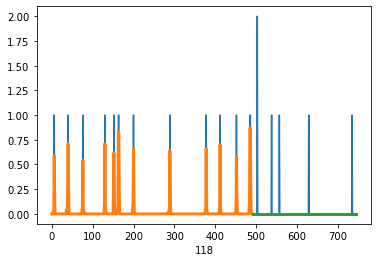

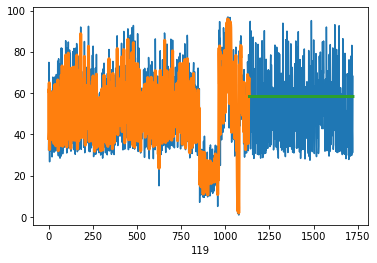

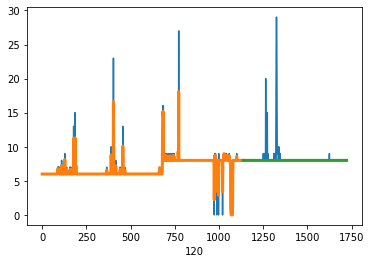

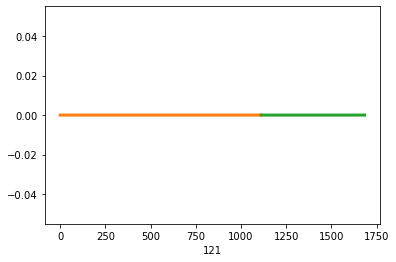

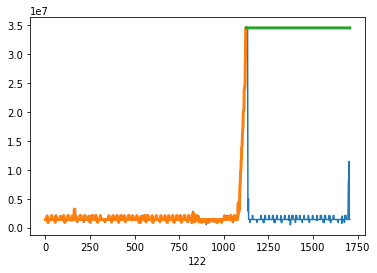

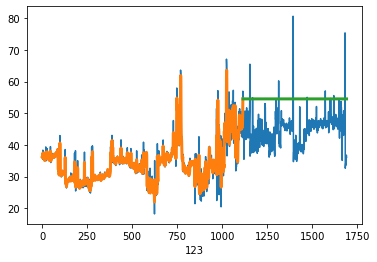

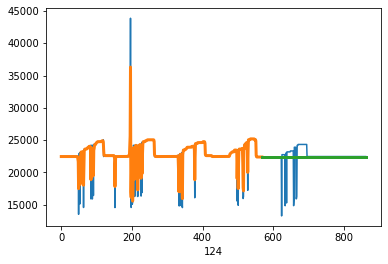

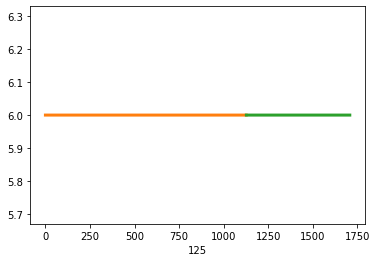

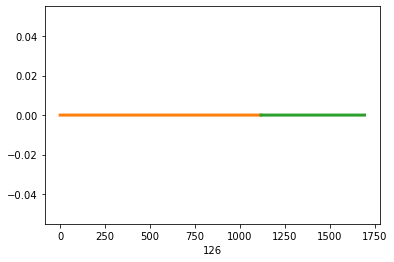

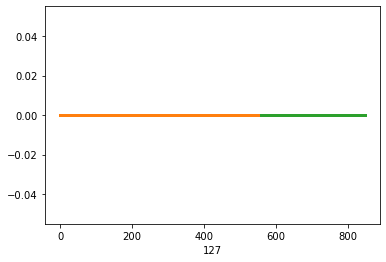

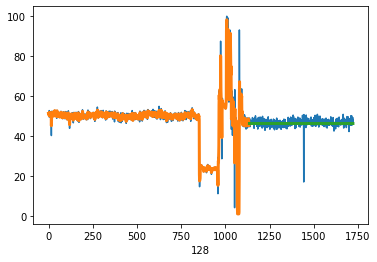

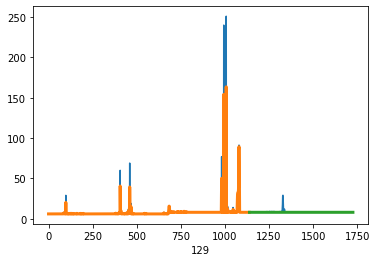

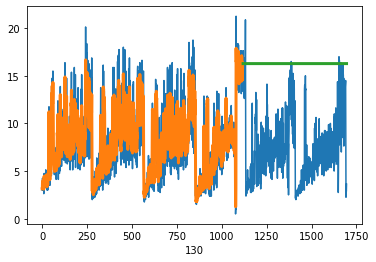

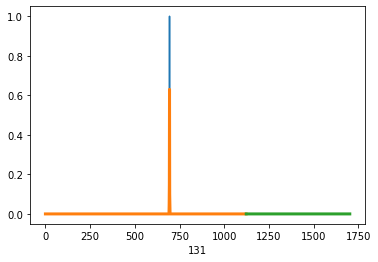

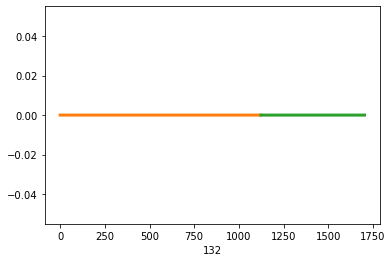

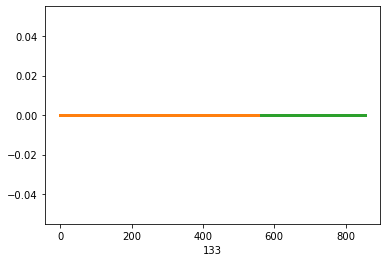

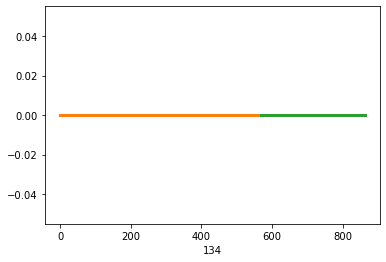

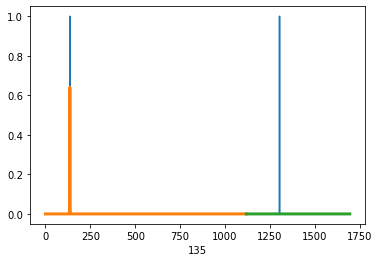

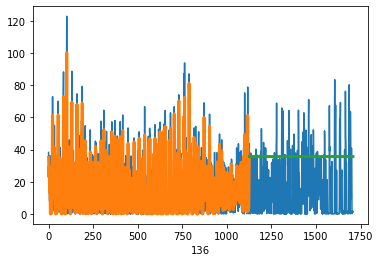

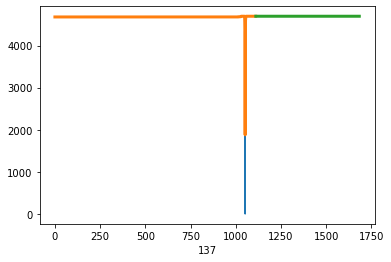

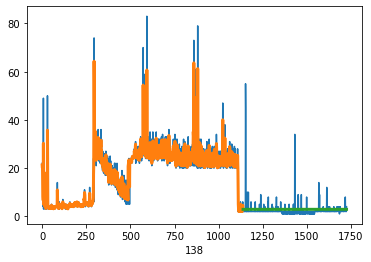

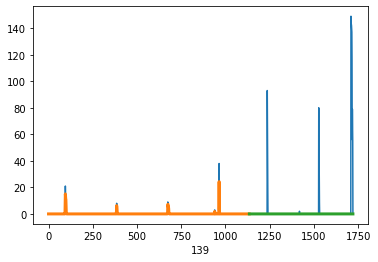

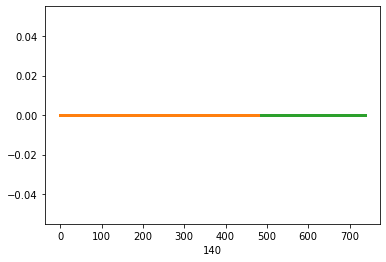

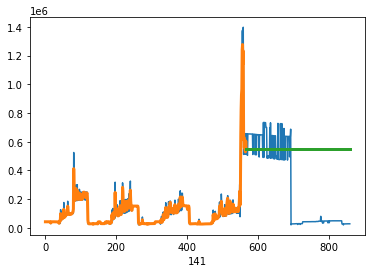

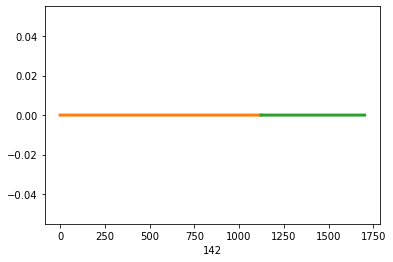

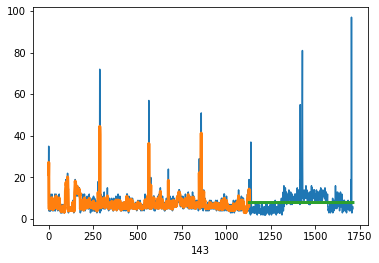

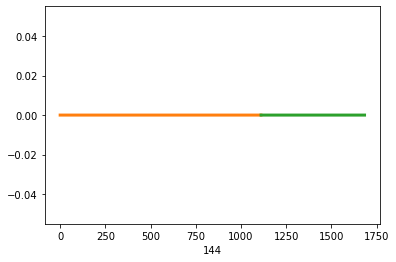

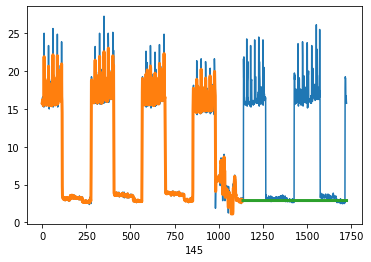

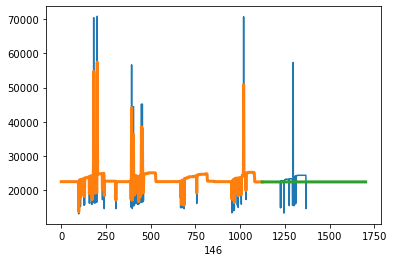

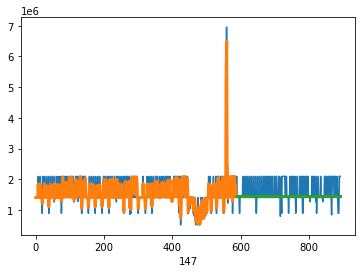

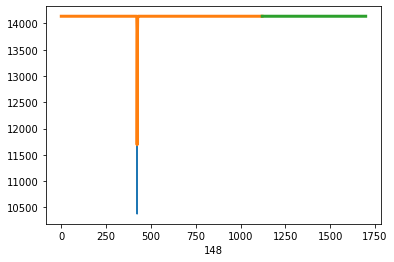

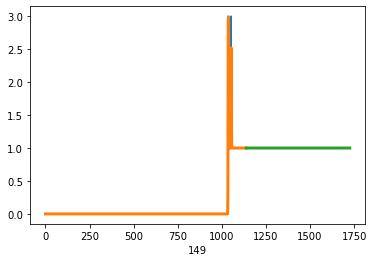

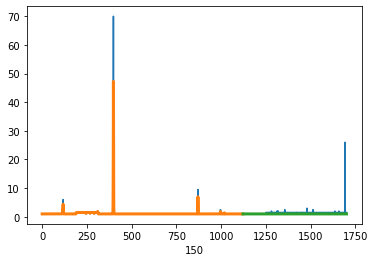

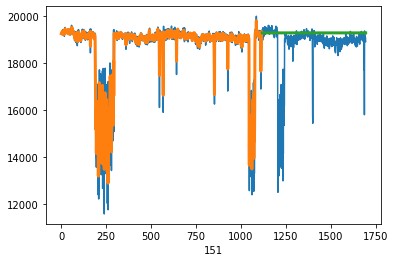

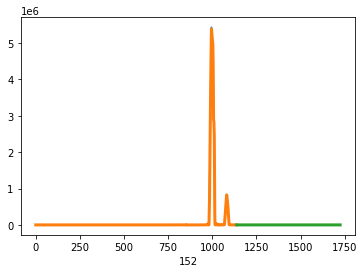

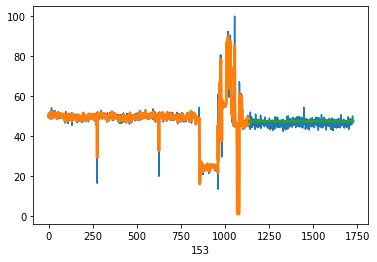

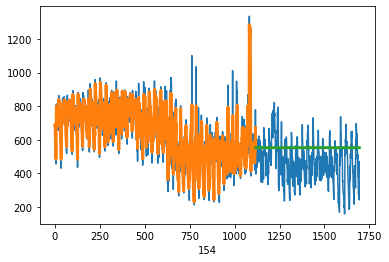

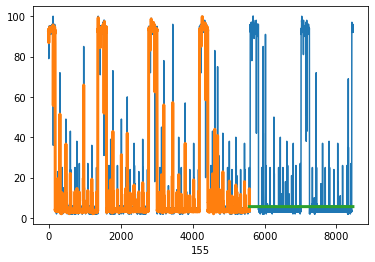

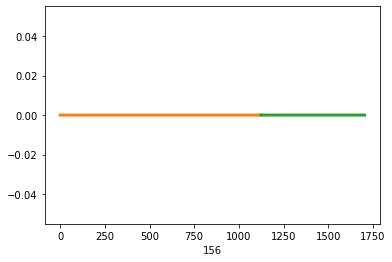

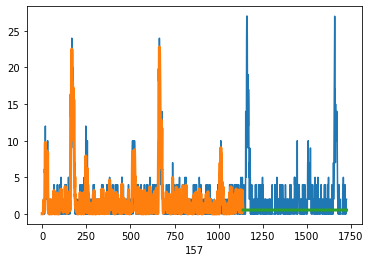

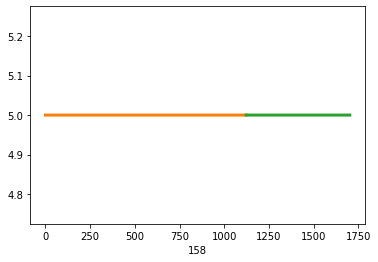

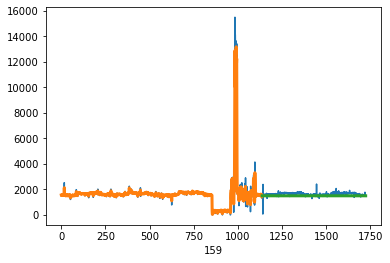

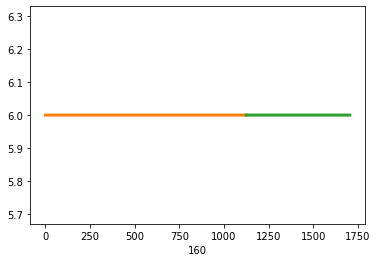

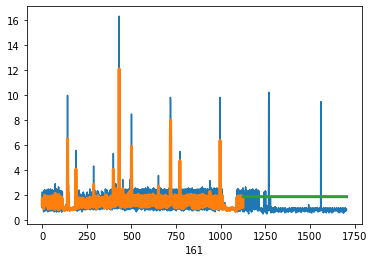

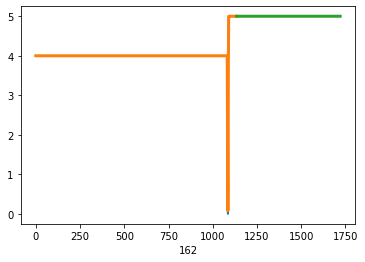

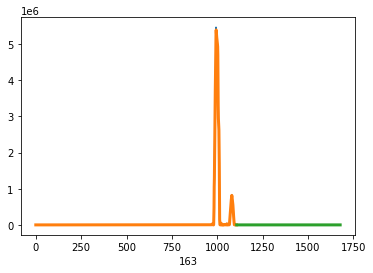

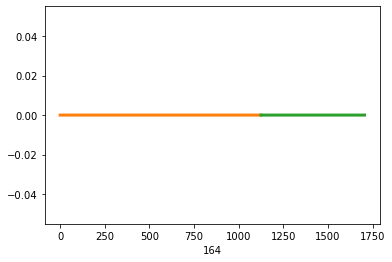

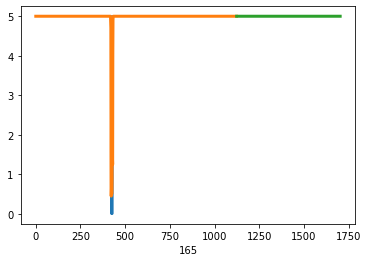

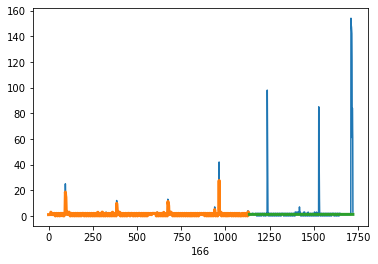

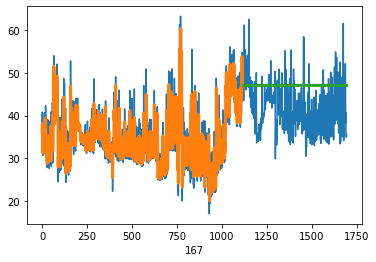

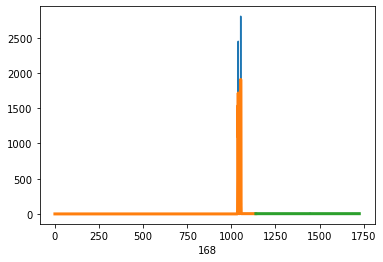

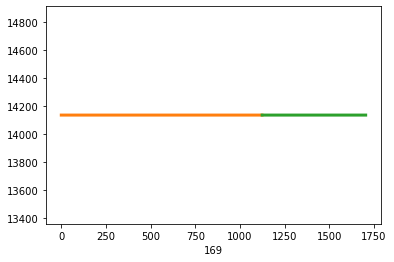

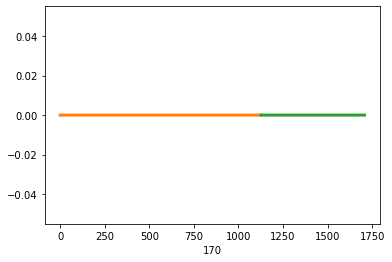

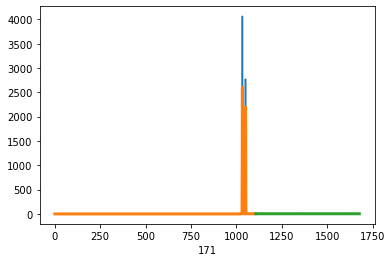

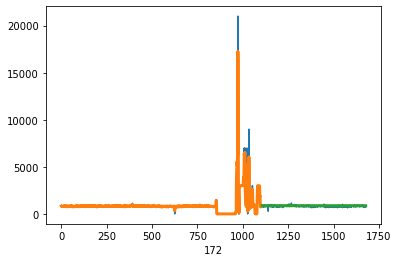

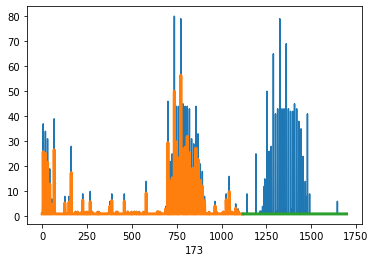

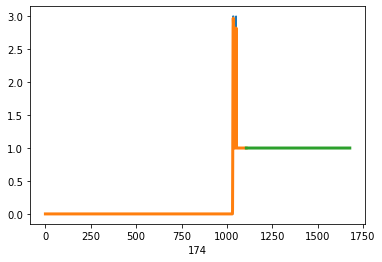

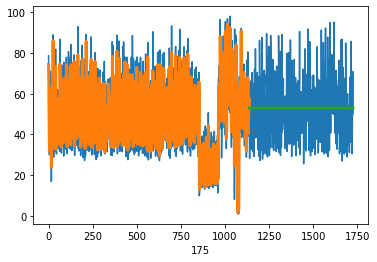

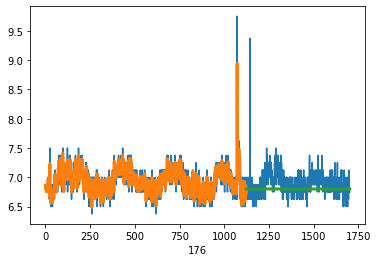

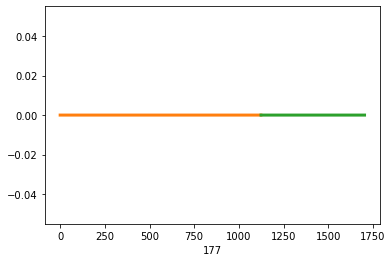

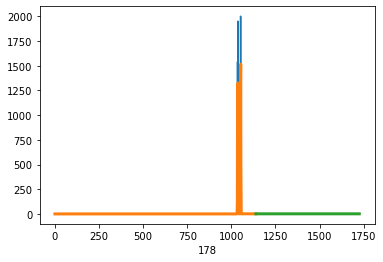

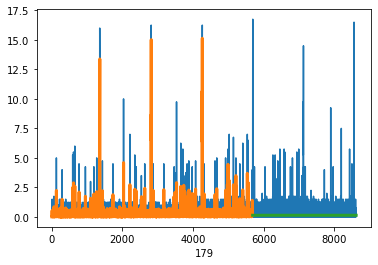

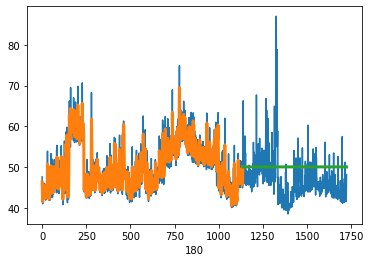

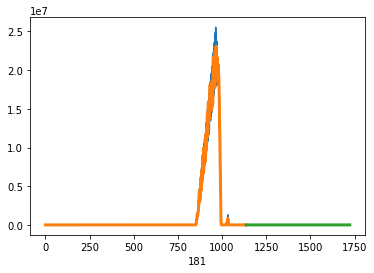

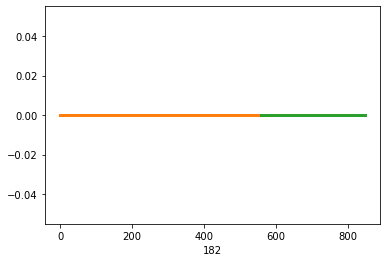

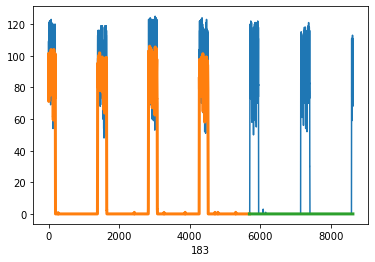

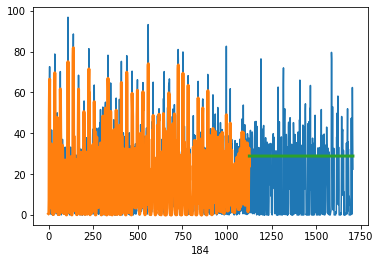

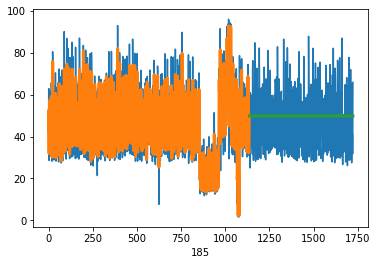

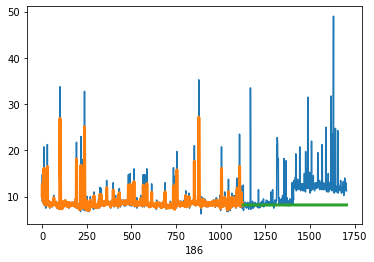

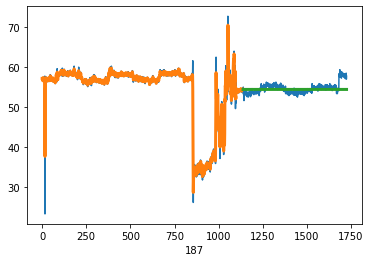

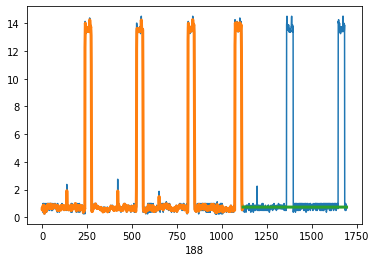

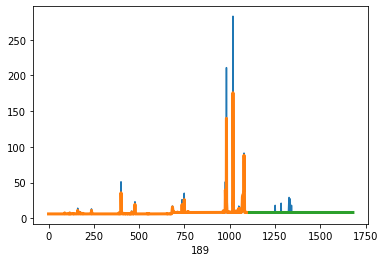

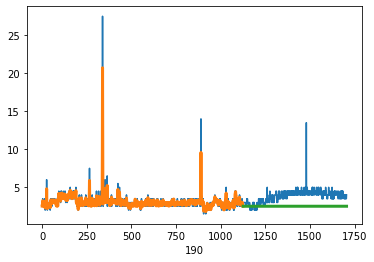

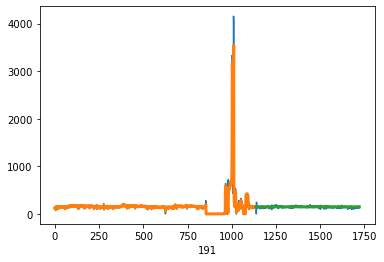

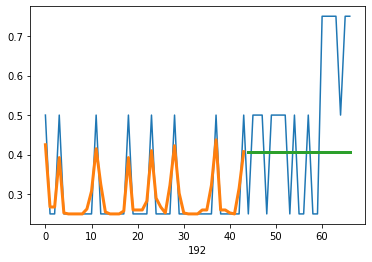

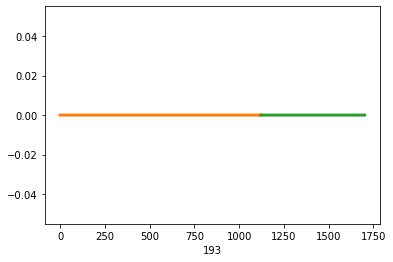

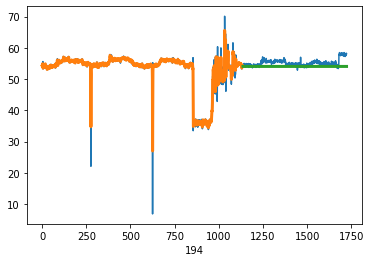

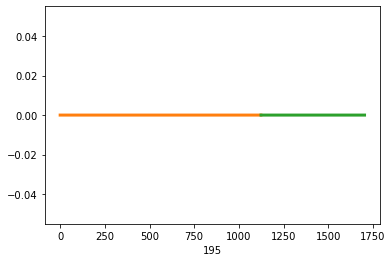

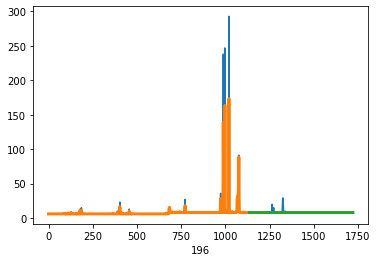

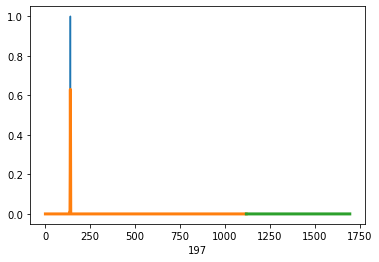

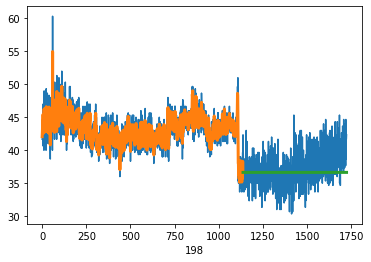

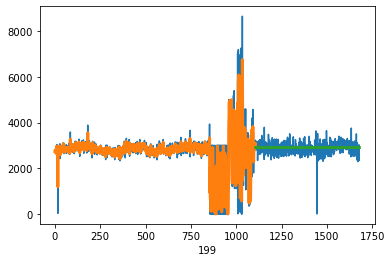

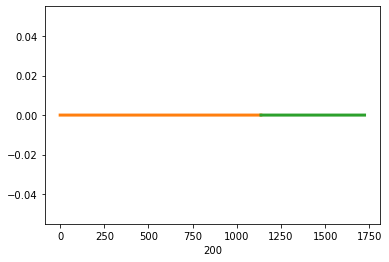

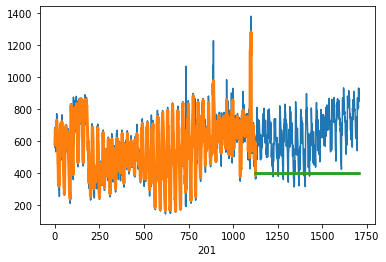

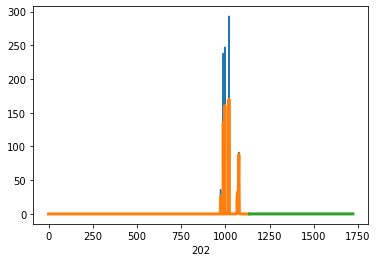

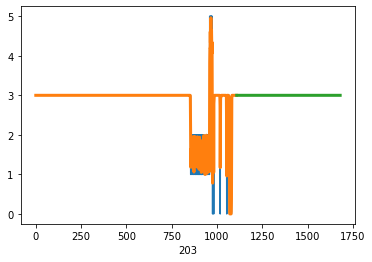

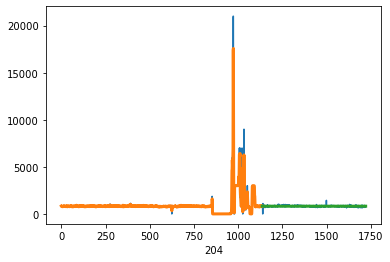

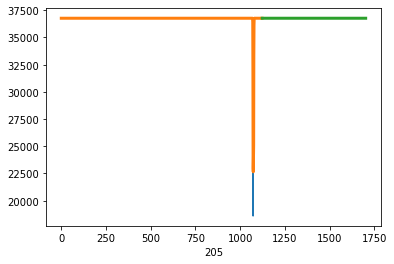

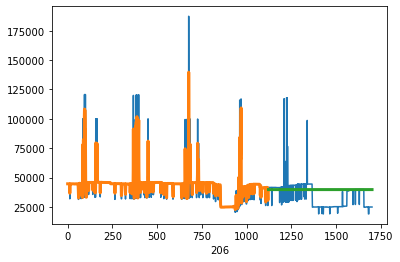

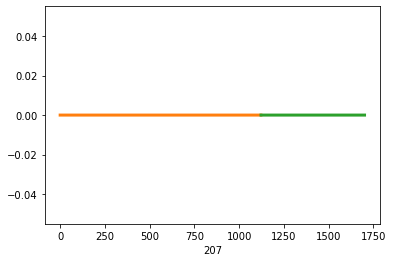

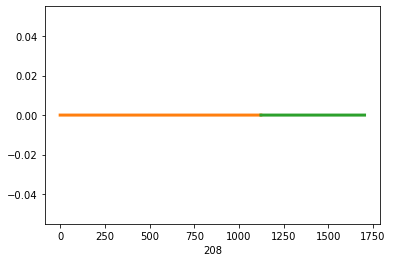

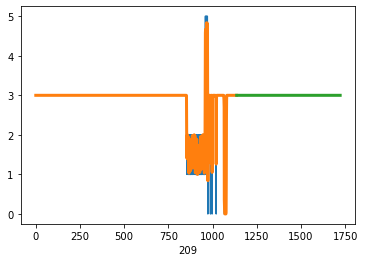

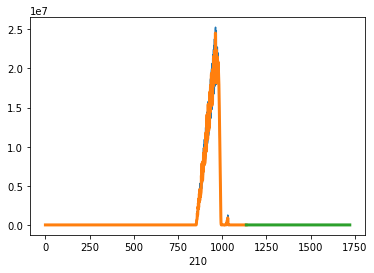

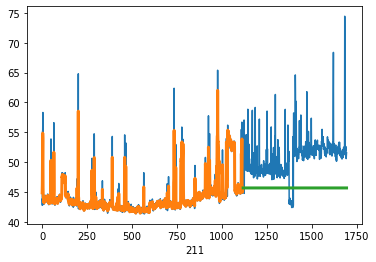

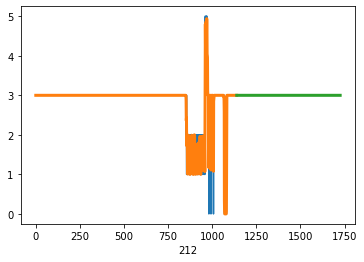

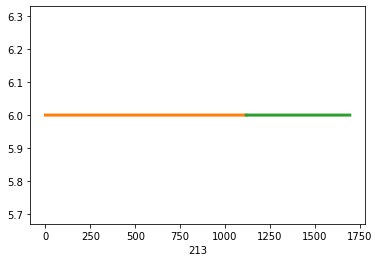

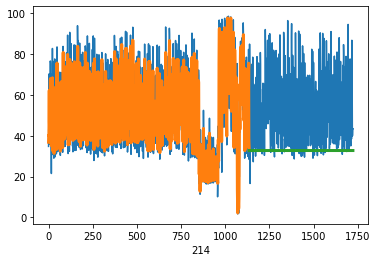

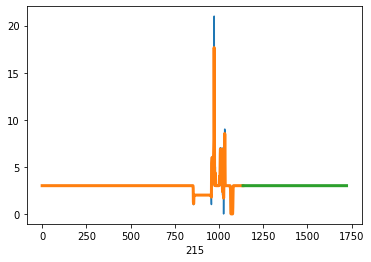

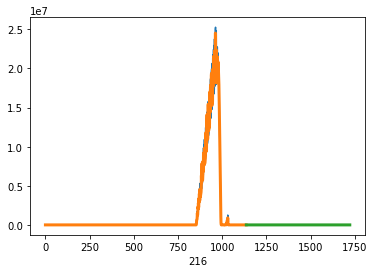

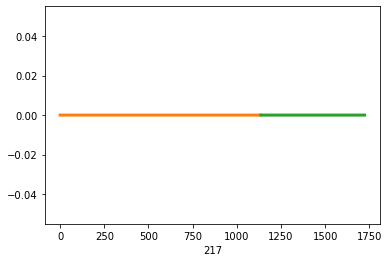

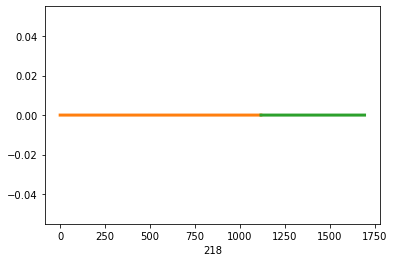

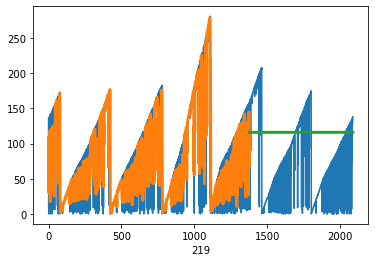

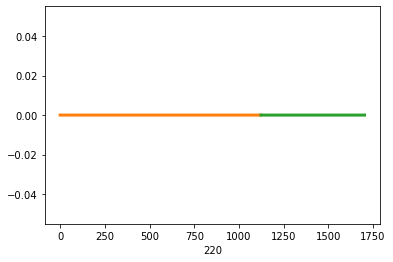

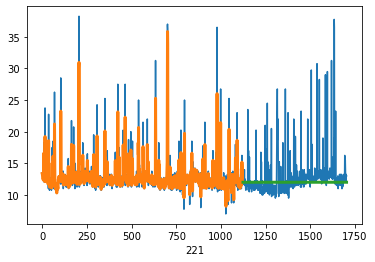

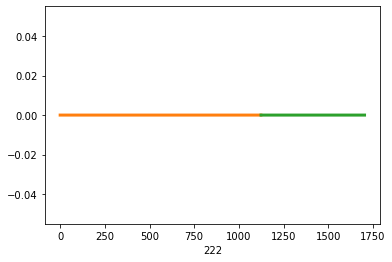

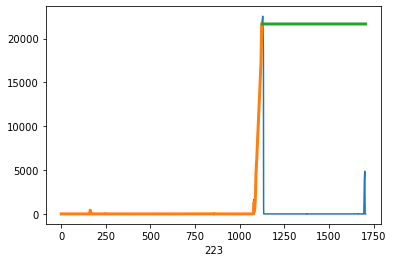

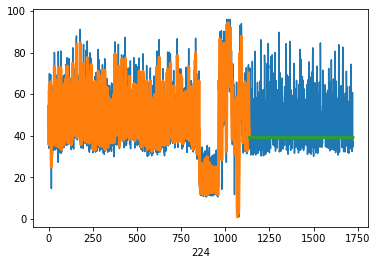

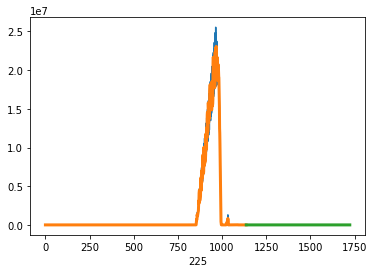

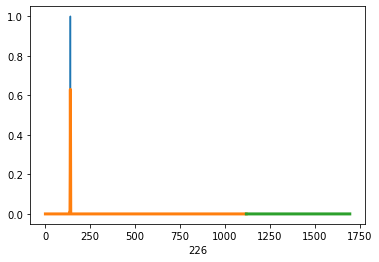

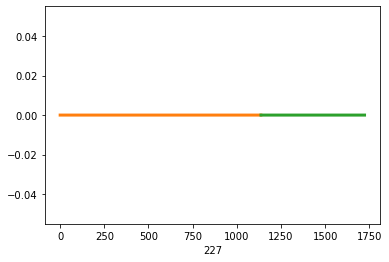

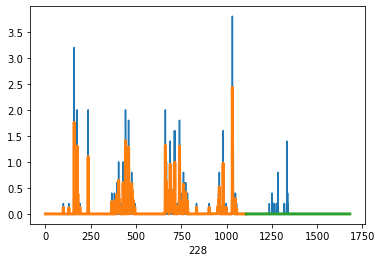

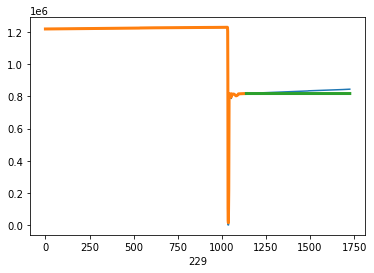

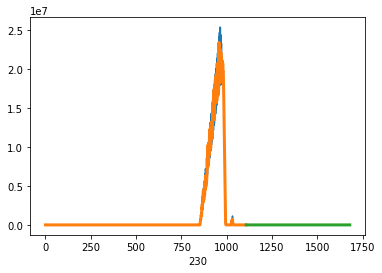

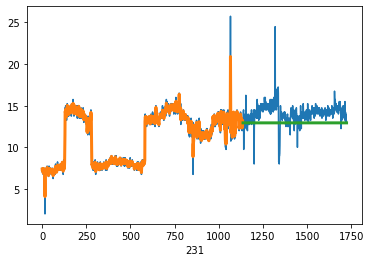

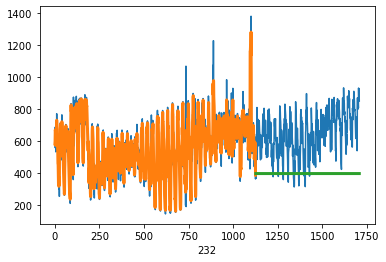

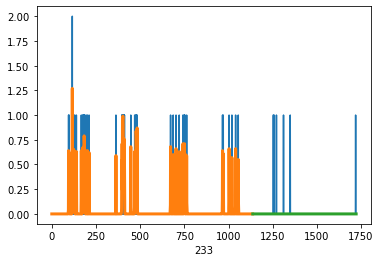

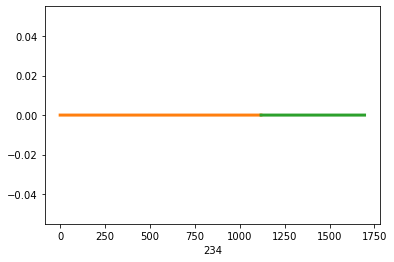

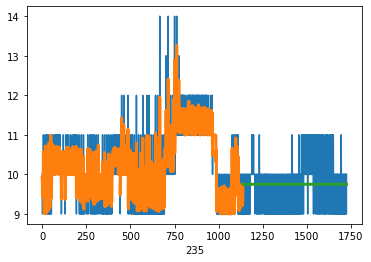

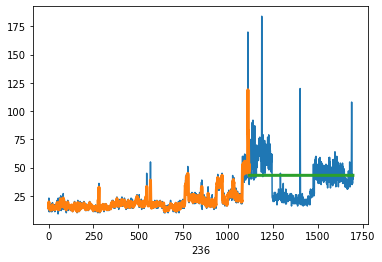

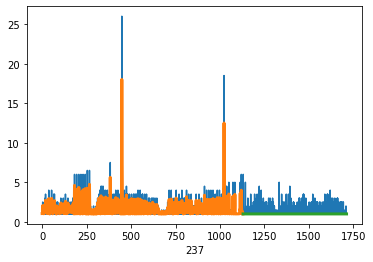

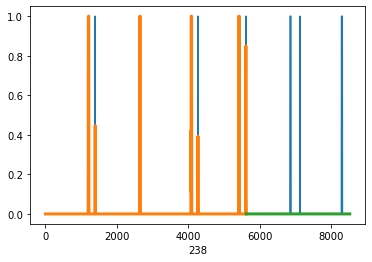

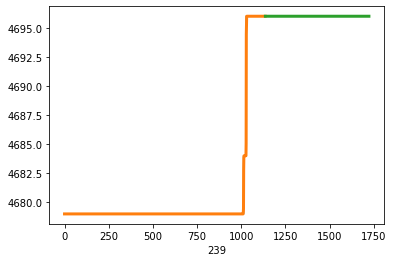

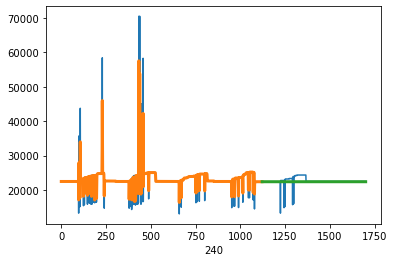

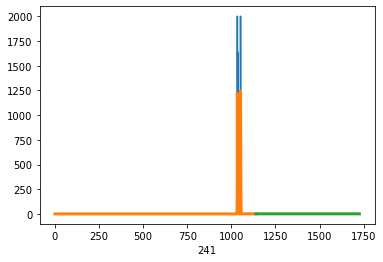

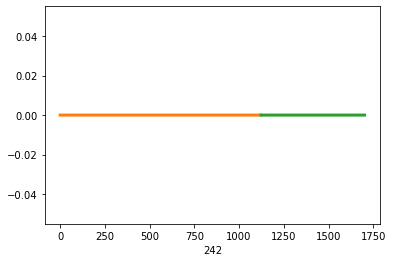

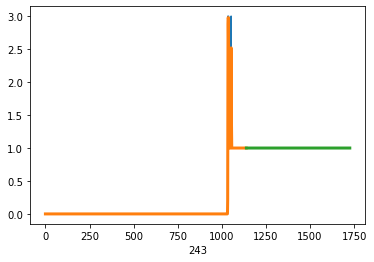

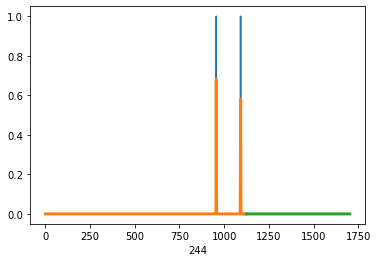

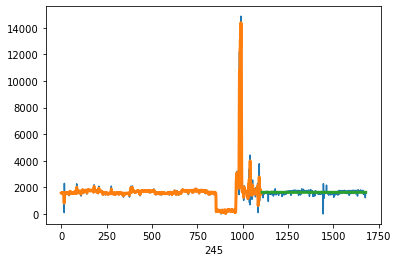

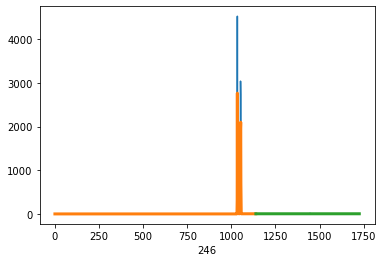

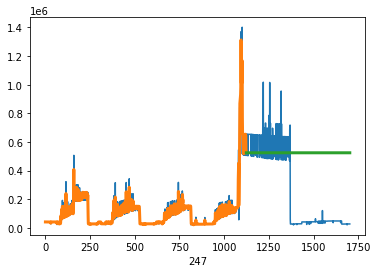

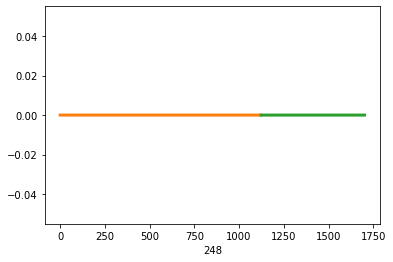

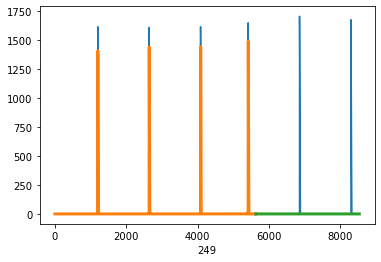

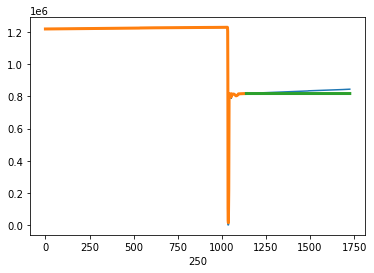

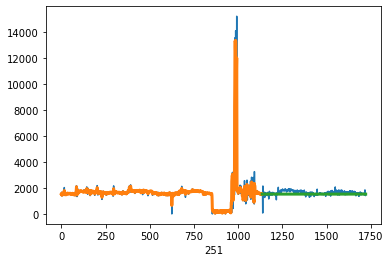

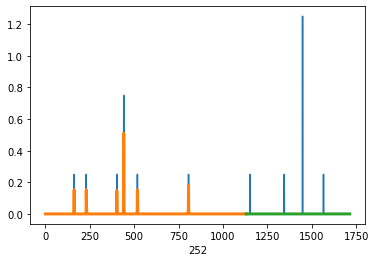

In [7]:
# Plot outputs
for i in range(len(keys_id)):
    indx = keys_id[i]
    fig, ax = plt.subplots()
    # shift train predictions for plotting
    trainPlot = np.empty_like(dic_id[indx][1].reshape(-1,1))
    trainPlot[:, :] = np.nan
    trainPlot[:len(dic_id[indx][3][2]), :] = dic_id[indx][3][2].reshape(-1,1)
    # shift test predictions for plotting
    validPlot = np.empty_like(dic_id[indx][1].reshape(-1,1))
    validPlot[:, :] = np.nan
    validPlot[len(dic_id[indx][3][2]):len(dic_id[indx][1]), :] = dic_id[indx][4][2].reshape(-1,1)
    # plot baseline and predictions
    ax.set_xlabel(str(i))
    ax.plot(dic_id[indx][1].reshape(-1,1))
    ax.plot(trainPlot, linewidth=3)
    ax.plot(validPlot, linewidth=3)
plt.show